<a href="https://colab.research.google.com/github/Arup3201/SmartFlow-Traffic-Detector/blob/main/notebooks/feature_extraction_of_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting Features from the Images

## Histogram Oriented Gradients (HOG)

**Steps to calculate the HOG features of the image:**

1. *Image Size Reset*: Take the image and resize in into your choice of size e.g. 64X128 pixels (here 64 is height and 128 is
width).

2. *Normalization to avoid overflow*: Normalize the image.

3. *Magnitude and Orientation Calculation*: Calculate the gradient of the image. The gradient is calculated by combining the magnitude and angel from the image. If we assume a 3X3 pixel image the $G_x$ and $G_y$ is calculated using the following formula- $$G_x(r, c) = I(r, c+1) - I(r, c-1) \ and\ G_y(r, c) = I(r+1, c) - I(r-1, c)$$

Then find the magnitude and angel of the image with following formulas-
$$magnitude = \sqrt{G_x^2+G_y^2}$$
$$angel=\vert{\tan^{-1}{(G_y / G_y)}}\vert$$

4. *Histogram Creation*: This step needs a little bit more explanation so we will go step by step to understand it.
  
  > Method 1: Simply put the orientation of each pixel into a table and keep count of how many pixels have that orientation. Finally, we make a histogram using this orientation and frequency table.

  > Method 2: Instead of using different orientatio values each time after seeing a new orientation value in the image, we make bins and each bin will be a collection of all orientations in the interval of that bin e.g. 0-20, 20-40, 40-60 etc. In this way we will go till 180 as this is the highest orientation of a pixel. Then, we do the same thing like before of counting the orientations present in the image and putting the frequency in the table which is now organized.

  > Method 3: We go a little bit further and instead of just counting the orientations from each bin, we put their magnitude value in that bin if the orientation falls under that particular bin.

  > Method 4: Instead of putting the magnitude in one bin where the orientation falls, we spread it towards the next bin as well to show the contribution of magnitude on both bins. If we have magnitude 13.6 and orientation 36, then 20-40 bin will get (36-20)/20 and 40-60 bin will get (40-36)/20. Remember that the contribution will be bigger for the bin which is closest.

5. *Calculating Histogram Gradients for 8X8 cells*: Method 4 will be applied to all cells that we will get after dividing the image into cells of 8X8 pixels. So, we will get 9X1 matrix for each cell.
> **NOTE** We can also change the pixels per cell from 8X8 to 16X16 or 32X32 or something else. Here 8X8 means 8 pixels. So, for 64X128 image horizontally we will get 8 such blocks and vertically we get 16 blocks. Likewise, we can change the orientations from 9 to something else which means how many buckets or bins do we want in the histogram?

6. Normalization of Gradients: Normalization is important because the image will have lots of lighting which will hinder the feature. Although we can't totally negate the effect but with normalization we can reduce it to some extent. To normalize the gradients, we take 16X16 block and use normalization inside this block and then slide it across the image. Each 16X16 block contains 4 8X8 cells and each contains 9X1 matrix making a total 36X1 matrix. When sliding the block, we jump by 8 pixels as pixels per cell is 8.

Normalization method: we take all values inside the 36X1 matrix, take their squares, add them and take the square root of that addition. We get a normalizer (k) and we divide each value of 36X1 matrix by k. The normalized vector size becomes 36X1.


For better understanding read the [blog](https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/#h-different-methods-to-create-histograms-using-gradients-and-orientation) written by Aishwarya Singh.

To understand the steps and equations, check out this [blog](https://towardsdatascience.com/hog-histogram-of-oriented-gradients-67ecd887675f) from towardsdatascience by Mrinal Tyagi.

In [1]:
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

import math

In [2]:
%matplotlib inline

In [3]:
# Clone the github repo to use the following code
!git clone https://github.com/Arup3201/SmartFlow-Traffic-Detector.git
%cd SmartFlow-Traffic-Detector/notebooks

Cloning into 'SmartFlow-Traffic-Detector'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 47 (delta 13), reused 19 (delta 1), pack-reused 0
Receiving objects: 100% (47/47), 844.45 KiB | 13.40 MiB/s, done.
Resolving deltas: 100% (13/13), done.
/content/SmartFlow-Traffic-Detector/notebooks


In [4]:
%pwd

'/content/SmartFlow-Traffic-Detector/notebooks'

*Open the Image and Resize it.*

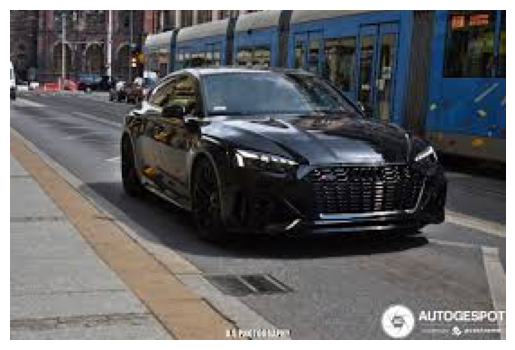

In [41]:
car = Image.open('../data/test_images/car-1.jpg')
plt.imshow(car)
plt.axis("off")
plt.show()

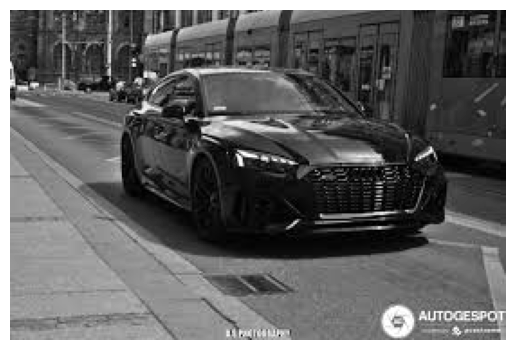

In [42]:
car_gray = car.convert('L')
plt.imshow(car_gray, cmap="gray")
plt.axis("off")
plt.show()

(-0.5, 127.5, 63.5, -0.5)

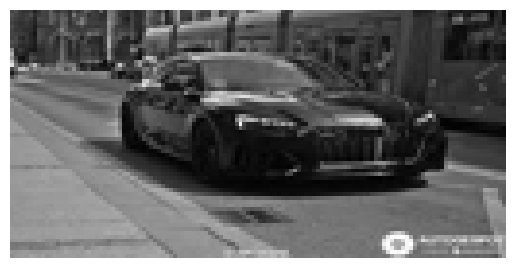

In [6]:
car_resized = car_gray.resize((128, 64)) # (width, height)
plt.imshow(car_resized, cmap="gray")
plt.axis("off")

In [7]:
car_arr = np.array(car_resized)

In [8]:
car_arr.shape

(64, 128)

In [21]:
car_arr[0, 0]

69

In [23]:
car_arr = car_arr.astype(np.float32)
car_arr[0, 0]

69.0

In [45]:
np.min(car_arr), np.max(car_arr)

(0.0, 255.0)

*Calculate the magnitude and orientation*

In [60]:
mag = []
ang = []

height = car_arr.shape[0]
width = car_arr.shape[1]

for r in range(height):
    magnitude_array = []
    angel_array = []

    for c in range(width):
        # Calculate gradient on x
        # When column is 0 or last column
        if c == 0:
            Gx = car_arr[r, c+1] - 0
        elif c == width-1:
            Gx = 0 - car_arr[r, c-1]
        else:
            Gx = car_arr[r, c+1] - car_arr[r, c-1]

        # Calculate gradient on y
        # When row is 0 or last row
        if r == 0:
            Gy = car_arr[r+1, c] - 0
        elif r == height-1:
            Gy = 0 - car_arr[r-1, c]
        else:
            Gy = car_arr[r+1, c] - car_arr[r-1, c]

        # Calculate magnitude
        magnitude = math.sqrt(Gx**2 + Gy**2)
        magnitude_array.append(round(magnitude, 9))

        # Calculate orienta
        if Gx == 0:
            angel = math.degrees(0.0)
        else:
            angel = math.degrees(abs(math.atan2(Gy, Gx)))

        angel_array.append(round(angel, 9))

    mag.append(magnitude_array)
    ang.append(angel_array)

In [61]:
mag = np.array(mag)
ang = np.array(ang)

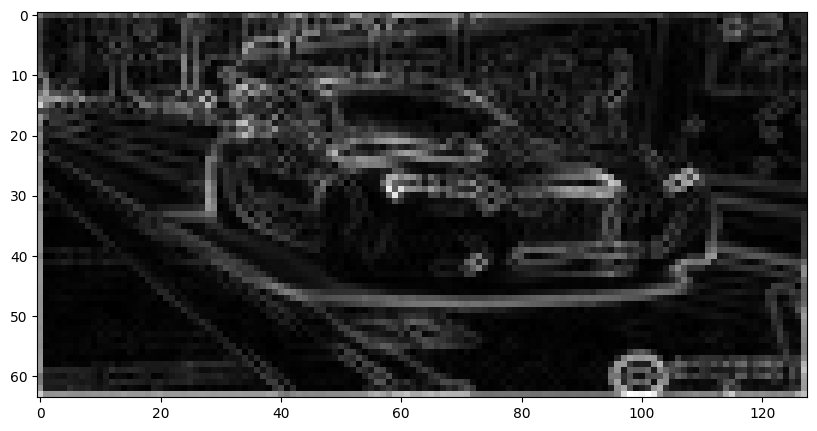

In [62]:
plt.figure(figsize=(16, 5))
plt.imshow(mag, cmap="gray")
plt.show()

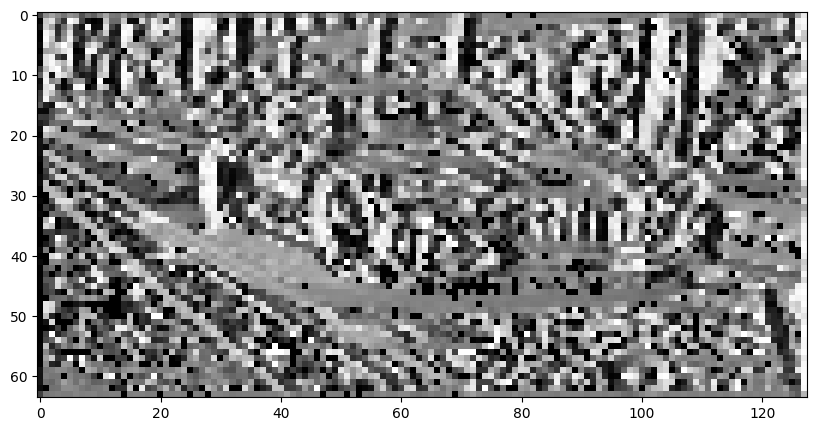

In [63]:
plt.figure(figsize=(16, 5))
plt.imshow(ang, cmap="gray")
plt.show()

In [64]:
np.max(mag), np.min(mag)

(262.773666869, 0.0)

In [65]:
np.max(ang), np.min(ang)

(180.0, 0.0)

*Create $9X1$ histogram matrix for each $8X8$ cell*

In [71]:
def generate_histogram(orientations, magnitudes, buckets=9):
  matrix = np.zeros(shape=(buckets, 1))
  step_size = 180//buckets

  pixels_per_cell = orientations.shape[0]

  for r in range(pixels_per_cell):
    for c in range(pixels_per_cell):
      # Take the magnitude and angel
      theta = orientations[r, c]
      magnitude = magnitudes[r, c]

      # Find the jth and j+1th bin in which the orientation falls
      if theta == 180:
        j_bin = buckets - 1
      else:
        j_bin = int(theta / step_size)

      j_1_bin = int(theta / step_size) % buckets # When j = 8 next is j+1 = 0

      # Calculate the jth and j+1th bins contribution to the orientation
      Vj = ((j_bin * step_size + step_size) - theta) / step_size # (40-36)/20
      Vj_1 = (theta - (j_bin * step_size)) / step_size # (36-20)/20

      matrix[j_bin] = Vj * magnitude
      matrix[j_1_bin] = Vj_1 * magnitude

  return matrix

In [72]:
generate_histogram(ang[:8, :8], mag[:8, :8])

array([[23.07541826],
       [ 0.73399504],
       [ 5.03727637],
       [ 1.15211686],
       [ 9.38680746],
       [11.65941956],
       [ 6.6013639 ],
       [19.60048184],
       [19.34420433]])

In [79]:
def histograms_per_cell(magnitudes, orientations, pixels_per_cell=8, buckets=9):
  h_limit = magnitudes.shape[1] // pixels_per_cell - 1
  v_limit = magnitudes.shape[0] // pixels_per_cell - 1

  hist_matrices = []

  for i in range(h_limit+1):
    hists = []
    for j in range(v_limit+1):
      magnitude_cell = magnitudes[i*pixels_per_cell:(i+1)*pixels_per_cell-1,
                                 j*pixels_per_cell:(j+1)*pixels_per_cell-1]
      orientation_cell = orientations[i*pixels_per_cell:(i+1)*pixels_per_cell-1,
                                      j*pixels_per_cell:(j+1)*pixels_per_cell-1]

      histogram = generate_histogram(orientation_cell, magnitude_cell, buckets)

      hists.append(histogram)

    hist_matrices.append(hists)

  return np.array(hist_matrices)

In [80]:
cell_histograms = histograms_per_cell(mag, ang)

In [81]:
cell_histograms.shape

(16, 8, 9, 1)

*Normalizing the cells*

In [87]:
# BUG FIX
def normalize_gradients(histograms, cells_per_block=2):
  h_limit = histograms.shape[1] - cells_per_block
  v_limit = histograms.shape[0] - cells_per_block

  normalized_blocks = []

  for i in range(h_limit+1):
    norm_blocks = []
    for j in range(v_limit+1):
      block = histograms[i:i+cells_per_block, j:j+cells_per_block, ...]

      block = block.reshape((-1, 1))

      norm = np.sqrt(np.sum(block**2))

      block = block / norm

      norm_blocks.append(block)

    normalized_blocks.append(norm_blocks)

  # return np.array(normalized_blocks)
  return normalized_blocks

In [88]:
normalized_histograms = normalize_gradients(cell_histograms)

In [84]:
normalized_histograms.shape

(7, 15)